## Importing libraries + reading data


In [ ]:
!pip install kneed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors

In [ ]:
# reading the data
store_data = pd.read_csv("/content/cleaned_store_data.csv")
store_data

,Ship Mode,Segment,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping days,latitude,longitude
0,Standard Class,Consumer,Henderson,Kentucky,42420.0,South,Furniture,Furnishings,182.7450,2.0,0.0,41.9136,3.0,37.83,-87.58
1,Second Class,Consumer,Henderson,Kentucky,42420.0,South,Furniture,Furnishings,731.9400,3.0,0.0,219.5820,3.0,37.83,-87.58
2,Second Class,Corporate,Los Angeles,California,90036.0,West,Office Supplies,Binders,14.6200,2.0,0.0,6.8714,4.0,34.06,-118.35
3,Standard Class,Consumer,Fort Lauderdale,Florida,33311.0,South,Furniture,Furnishings,957.5775,5.0,0.2,-383.0310,7.0,26.14,-80.17
4,Standard Class,Consumer,Fort Lauderdale,Florida,33311.0,South,Office Supplies,Binders,22.3680,2.0,0.2,2.5164,7.0,26.14,-80.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9437,Standard Class,Consumer,Athens,Georgia,30605.0,South,Technology,Phones,206.1000,5.0,0.0,55.6470,4.0,33.91,-83.32
9438,Standard Class,Consumer,Costa Mesa,California,92627.0,West,Furniture,Furnishings,91.9600,2.0,0.0,15.6332,5.0,33.64,-117.91
9439,Standard Class,Consumer,Costa Mesa,California,92627.0,West,Technology,Phones,258.5760,2.0,0.2,19.3932,5.0,33.64,-117.91
9440,Standard Class,Consumer,Costa Mesa,California,92627.0,West,Office Supplies,Binders,26.9680,4.0,0.0,13.3200,5.0,33.64,-117.91


In [ ]:
store_data.columns

Index(['Ship Mode', 'Segment', 'City', 'State', 'Postal Code', 'Region',
       'Category', 'Sub-Category', 'Sales', 'Quantity', 'Discount', 'Profit',
       'Shipping days', 'latitude', 'longitude'],
      dtype='object')

## Correlation + ANOVA

In [ ]:
numerical = store_data[['Sales', 'Quantity', 'Discount','Profit', 'Shipping days','latitude', 'longitude']]

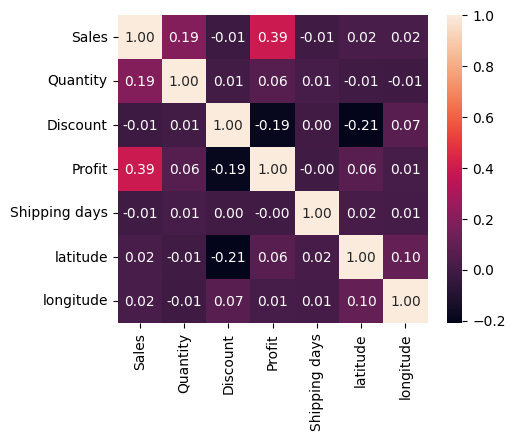

In [ ]:
# Correlation matrix
plt.figure(figsize=(5, 4))
sns.heatmap(numerical.corr(), annot=True, fmt=".2f")
plt.show()

After imputing the data, I analyzed the correlations between the numerical features again.
- Sales and profits are still moderately correlated (0.39) which implies higher sales lead to higher profits.
- Discount and Profit are still negatively correlated (-0.19). This indicates that higher discounts might be reducing profit margins.
- Sales and quantity are still positively correlated (0.19). This indicates that higher sales are somewhat associated with larger quantities sold.
- All other variables still suggest very low correlation indicating little to no direct impact.

We used the correlation matrix to determine how numerical features affect sales and profit. For categorical features, we can use ANOVA.

In [ ]:
def run_anova_for_profit(data, independent_vars, dependent_var='Profit'):
    results = {}
    for var in independent_vars:
        formula = f'{dependent_var} ~ Q("{var}")'
        model = ols(formula, data=data).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        results[var] = aov_table
        print(f"ANOVA for {var} on {dependent_var}:\n", aov_table, "\n")
    return results

categorical = ['Ship Mode', 'Segment', 'City', 'State', 'Postal Code', 'Region', 'Category', 'Sub-Category']
profit_anova_results = run_anova_for_profit(store_data, categorical)

ANOVA for Ship Mode on Profit:
                       sum_sq      df         F   PR(>F)
Q("Ship Mode")  5.981331e+04     3.0  0.414926  0.74229
Residual        4.535093e+08  9438.0       NaN      NaN 

ANOVA for Segment on Profit:
                     sum_sq      df         F    PR(>F)
Q("Segment")  8.993459e+04     2.0  0.935978  0.392239
Residual      4.534792e+08  9439.0       NaN       NaN 

ANOVA for City on Profit:
                  sum_sq      df        F    PR(>F)
Q("City")  2.646905e+07   530.0  1.04198  0.250486
Residual   4.271000e+08  8911.0      NaN       NaN 

ANOVA for State on Profit:
                   sum_sq      df         F        PR(>F)
Q("State")  1.880773e+07    48.0  8.465422  8.752821e-57
Residual    4.347614e+08  9393.0       NaN           NaN 

ANOVA for Postal Code on Profit:
                         sum_sq      df          F    PR(>F)
Q("Postal Code")  7.209083e+05     1.0  15.027939  0.000107
Residual          4.528482e+08  9440.0        NaN       NaN 

AN

The significant categorical features affecting 'Profit' are 'State', 'Postal Code', 'Region', and 'Category' and 'Sub-Category'. These factors should be carefully managed to optimize profitability. Variables like 'Ship mode', 'Segment', and 'City' show no significant impact, indicating that changes or variations in these areas are unlikely to affect profit margins materially.

This is useful because if 'Category' and 'Sub-Category' have significant effects on profit, then refining the product mix or focusing on high-margin categories could boost profitability. Ship mode and segment having no significant impact indicates that changes in these areas are unlikely to have a major financial impact. Geographical factors being significant helps sellers tailor their selling strategies based on regional variations.

## Model

In [ ]:
# features to use for PCA
numeric_features = ['Sales', 'Quantity', 'Discount']
categorical_features = ['Region', 'Category', 'Sub-Category']

# numeric_transformer: Standardizes the numeric features
# categorical_transformer: one hot encode categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit the preprocessor to the data and apply PCA
X_processed = preprocessor.fit_transform(store_data)
pca = PCA()
X_pca = pca.fit_transform(X_processed)

# Explained variance ratio for PCA components
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print('Explained Variance:', explained_variance)
print('Cumulative Variance:', cumulative_variance)

Explained Variance: [2.69739995e-01 2.22106093e-01 1.89561608e-01 1.23000211e-01
 6.58548906e-02 6.07581856e-02 4.31645291e-02 1.22900983e-02
 5.04208273e-03 2.88414712e-03 1.31316991e-03 1.05398690e-03
 8.00115868e-04 6.40171361e-04 5.61209410e-04 5.09842819e-04
 4.18023472e-04 1.93467435e-04 1.08173204e-04 9.47617802e-34
 5.01976049e-34]
Cumulative Variance: [0.26973999 0.49184609 0.6814077  0.80440791 0.8702628  0.93102098
 0.97418551 0.98647561 0.99151769 0.99440184 0.99571501 0.996769
 0.99756911 0.99820928 0.99877049 0.99928034 0.99969836 0.99989183
 1.         1.         1.        ]


Profit prediction

In [ ]:
# I select the the number of PCA components that explain 80-90% of the variance
n_components = next(x[0] for x in enumerate(cumulative_variance) if x[1] > 0.8) + 1
X_pca_reduced = X_pca[:, :n_components]
y = store_data['Profit']

# Splitting the data into training and testing sets and initialzing the model
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

MSE: 22110.948684027357
R-squared: 0.35976794155463376


In [ ]:
# Splitting the data into training and testing sets and initialzing the model
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 23517.80943756204
R-squared: 0.31903168147583516


Both linear regression and random forest use PCA-transformed features. These models have moderate predictive performance for the profit variable, explaining about 32-36% of the variance in the data.

I did not have the time to do this but the high MSE suggests there is room for improvement. I would focus more on hyperparameter tuning.

# Warehouse prediction

I want to predict what the optimal number of warehouses are for this store and where they should be located based on latitude and longitude data.

In [ ]:
warehouse_data = store_data[['City', 'State', 'Postal Code', 'Shipping days', 'Ship Mode', 'latitude', 'longitude']]

Since the elbow method is sensitive to the range of clusters you input, intuitively, it made sense to start at 4 since customers are distributed across 4 regions for the store.

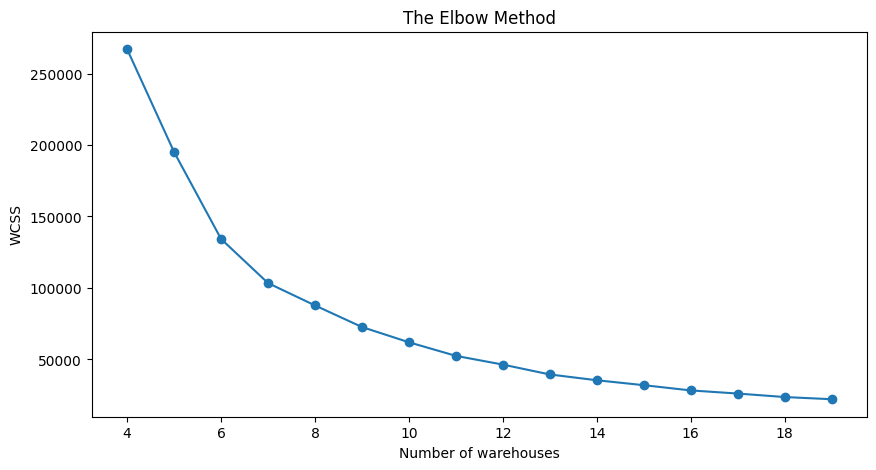

In [ ]:
# Define the range of clusters to try
range_clusters = range(4, 20)

wcss = [] # within cluster sum of squares
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=0)
    # Fit the KMeans algorithm on longitude, latitude data
    kmeans.fit(warehouse_data[['latitude', 'longitude']])
    wcss.append(kmeans.inertia_)

# Finding the optimal number of warehouses using the elbow method
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of warehouses')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from kneed import KneeLocator
# using an inbuilt package to identify the elbow
kneedle = KneeLocator(range_clusters, wcss, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow
print(f"Optimal number of warehouses: {optimal_k}")

Optimal number of warehouses: 7


While the above information is useful, I wanted to add a more business aspect to this model. I use K-means clustering to predict the optimal number of warehouses needed to minimize costs. The total cost is calculated by $Total Cost=(n_{cluster} \times C) +(S \times SSE)$

where $n_{cluster}$ is the number of warehouses, $C$ is the cost of setting up a warehouse, $S$ is the shipping cost factor. These can be changed based on store specifications.

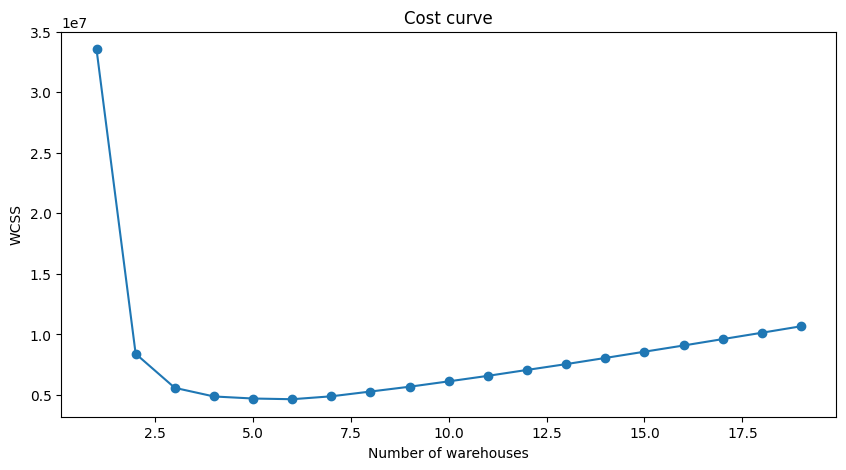

In [ ]:
#range of clusters to try
range_clusters = range(1, 20)

# Compute Cost for a given clustering, given as (n_cluster * C) + (S * SSE)
# C = cost per warehouse, cost to ship order = S * |location - warehouse|_2^2
C = 550000 # average cost to set up a warehouse (google)
S = 10
cost = []
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, n_init=5, random_state=0)  # Reduced n_init from default 10 to 5
    kmeans.fit(warehouse_data[['latitude', 'longitude']])
    cost.append(kmeans.inertia_ * S + k * C)

# Plotting the results onto a line graph to observe the costs
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, cost, marker='o')
plt.title('Cost curve')
plt.xlabel('Number of warehouses')
plt.ylabel('Cost')
plt.show()

In [ ]:
optimal_k = np.argmin(cost) + 1
print(f"Optimal number of warehouses: {optimal_k}")

Optimal number of warehouses: 6


In [ ]:
optimal_k = 6

# Fitting the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(warehouse_data[['latitude', 'longitude']])

# getting warehouse locations
warehouse_locations = kmeans.cluster_centers_
warehouse_locations_df = pd.DataFrame(warehouse_locations, columns=['latitude', 'longitude'])

# Using Nearest Neighbors to find the closest city and state for each warehouse location
n = NearestNeighbors(n_neighbors=1).fit(warehouse_data[['latitude', 'longitude']])
distances, indices = n.kneighbors(warehouse_locations_df[['latitude', 'longitude']])

# Map the nearest city and state
warehouse_locations_df['city'] = warehouse_data.loc[indices.flatten(), 'City'].values
warehouse_locations_df['state'] = warehouse_data.loc[indices.flatten(), 'State'].values

warehouse_locations_df

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,latitude,longitude,city,state
0,40.858926,-86.289890,Lafayette,Indiana
1,35.282227,-118.562658,Bakersfield,California
2,31.808047,-81.848218,Jacksonville,Florida
3,46.960820,-121.966367,Covington,Washington
4,40.489072,-74.554474,New Brunswick,New Jersey
5,32.977230,-97.440953,Fort Worth,Texas


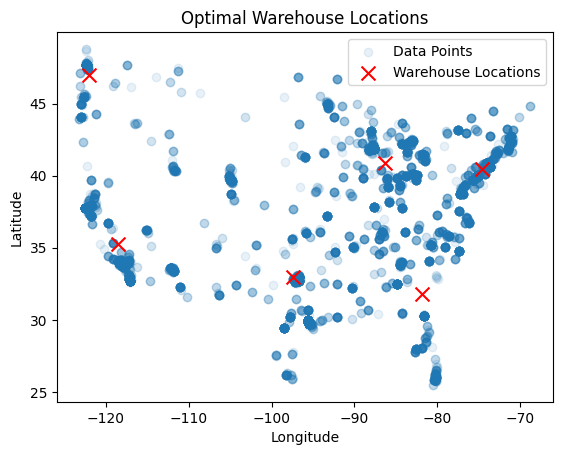

In [ ]:
# Plot the optimal warehouse locations
plt.scatter(warehouse_data['longitude'], warehouse_data['latitude'], alpha=0.1, label='Data Points')
plt.scatter(warehouse_locations[:, 1], warehouse_locations[:, 0], color='red', marker='x', label='Warehouse Locations', s=100)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Optimal Warehouse Locations')
plt.legend()
plt.show()

These locations cover a wide geographic area in the United States, especially the East and West coast which contribute the most towards sales and profit.